# 第七章第六节 albumentations


# 上手 demo


albumentations 的使用与 transforms 几乎一模一样，请看第一个示例。

需要注意在 dataset 中使用 self.transforms 时需要将图片变为 ndarray（pytorch 的 transform 是 PIL.Image 形式）


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A
import numpy as np
import cv2

torch.Size([2, 512, 512, 3]) tensor([1, 0])


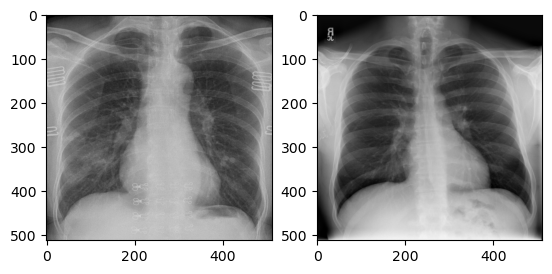

请多次运行此cell，观察ShiftScaleRotate函数的随机性对图片的作用，也可自行设置变换方法，观察变换方法的作用


In [ ]:
# img_: 一张已经经过 transform_train 处理后的图像（Tensor 格式，通常是 [C, H, W]）
# transform_train: 一个 torchvision.transforms.Compose([...])，定义了训练时的图像预处理操作
def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    # 通过字符串方式检查 transform 中是否使用了 transforms.Normalize
    if 'Normalize' in str(transform_train):
        # filter(...)：从 transform_train.transforms 中找出 transforms.Normalize。
        # mean、std 是归一化时用的参数（如 mean=[0.5, 0.5, 0.5]）。
        # img_ = img_ * std + mean：反归一化，恢复原始像素分布。
        norm_transform = list(filter(lambda x: isinstance(
            x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(
            norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(
            norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])
    # 将 Tensor 从 PyTorch 格式 [C, H, W] 转换为 NumPy 和 PIL 更习惯的 [H, W, C]
    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    # 如果图像是通过 transforms.ToTensor() 得来的，那么像素值会在 [0, 1] 之间。
# 所以需要乘以 255，恢复为标准图像值（[0, 255]）。
    if 'ToTensor' in str(transform_train) or img_.max() < 1:
        img_ = img_.detach().numpy() * 255
    # img_.astype('uint8')：像素值应该是 0~255 的整数。
# shape[2] == 3：RGB 图像。
# shape[2] == 1：灰度图。
# 其他通道数（如 4，alpha通道）会抛出异常
    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    # 因为 PIL 期望灰度图是二维数组，所以需要 squeeze 去掉多余的单维度。
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception(
            "Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]))
    return img_


class COVID19Dataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        """
        获取数据集的路径、预处理的方法
        """
        self.root_dir = root_dir
        self.txt_path = txt_path
        self.transform = transform
        self.img_info = []  # [(path, label), ... , ]
        self.label_array = None
        self._get_img_info()

    def __getitem__(self, index):
        """
        输入标量index, 从硬盘中读取数据，并预处理，to Tensor
        :param index:
        :return:
        """
        path_img, label = self.img_info[index]
        img_bgr = cv2.imread(path_img)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            img = self.transform(image=img_rgb)
        return img, label

    def __len__(self):
        if len(self.img_info) == 0:
            raise Exception("\ndata_dir:{} is a empty dir! Please checkout your path to images!".format(
                self.root_dir))  # 代码具有友好的提示功能，便于debug
        return len(self.img_info)

    def _get_img_info(self):
        """
        实现数据集的读取，将硬盘中的数据路径，标签读取进来，存在一个list中
        path, label
        :return:
        """
        # 读取txt，解析txt
        with open(self.txt_path, "r") as f:
            txt_data = f.read().strip()
            txt_data = txt_data.split("\n")
        self.img_info = [(os.path.join(self.root_dir, i.split()[0]), int(i.split()[2]))
                         for i in txt_data]


# you can download the datasets from
# https://pan.baidu.com/s/18BsxploWR3pbybFtNsw5fA  code：pyto
# path to datasets——covid-19-demo
root_dir = r"D:\ai\pytorch\l-PyTorch-Tutorial-2nd\data\datasets\covid-19-demo"
img_dir = os.path.join(root_dir, "imgs")
path_txt_train = os.path.join(root_dir, "labels", "train.txt")
train_transform = A.Compose(
    [
        A.Resize(512, 512),
        # ShiftScaleRotate：
        # shift_limit=0.05：最多平移图像宽/高的 5%
        # scale_limit=0.05：最多缩放 ±5%
        # rotate_limit=55：随机旋转 ±55 度
        # p=0.5：每次有 50% 概率应用该变换 ➜ 因此运行多次会看到不同结果
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,
                           rotate_limit=55, p=0.5),
    ]
)
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=train_transform)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data["image"].shape, labels)
    img_1 = data["image"][0]
    img_2 = data["image"][1]
    plt.subplot(121).imshow(img_1)
    plt.subplot(122).imshow(img_2)
    plt.show()
print("请多次运行此cell，观察ShiftScaleRotate函数的随机性对图片的作用，也可自行设置变换方法，观察变换方法的作用")

# dual transforms


图像标签对形式的数据增强  
这里以图像分割为例展示图像标签对的使用，与图像分类中不同之处只在于需要数据、标签同时出入 transforms 函数中，并且读取时依据 key-value 对进行读取。


In [7]:
# 可视化图像和掩码（mask）对，支持显示原始图像和经过变换后的图像对比。
# image：变换后的图像（如经过 A.Compose() 数据增强）
# mask：变换后的掩码
# original_image / original_mask：如果提供了，表示变换前的原始图像和掩码
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    # 没有原图（只看变换后的图像和 mask）
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))
        # 创建 2 行 1 列的图像
# 第一行显示变换后的 image
# 第二行显示变换后的 mask
        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        # 提供了原图（显示原图与变换后的对比）
        f, ax = plt.subplots(2, 2, figsize=(8, 8))
        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
    plt.show()

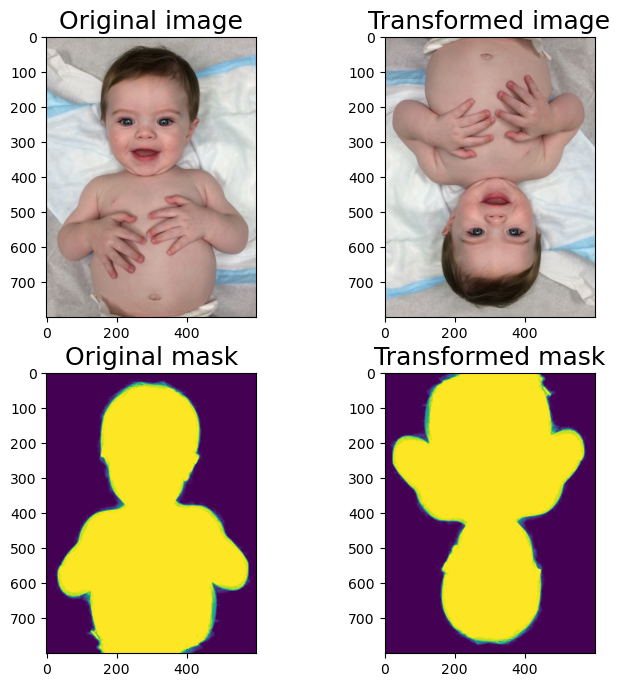

In [10]:
from albumentations import (
    HorizontalFlip, Perspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    GaussNoise, MotionBlur, MedianBlur, PiecewiseAffine,
    Sharpen, RandomBrightnessContrast,  OneOf, Compose
)

# download from :
# 链接：https://pan.baidu.com/s/1Kk4r0m0YFvB1iycyGI39Cg
# 提取码：gmsr
path_img = r"D:\ai\pytorch\l-PyTorch-Tutorial-2nd\data\imgs\00016.png"
path_mask = r"D:\ai\pytorch\l-PyTorch-Tutorial-2nd\data\imgs\00016_matte.png"
assert os.path.exists(path_img), f"图像路径不存在: {path_img}"
assert os.path.exists(path_mask), f"掩码路径不存在: {path_mask}"
image = cv2.imread(path_img)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path_mask, 0)
data_transform = A.Compose(
    [
        A.RandomRotate90(p=1),
        A.HueSaturationValue(p=0.5)
    ]
)
# 这一行模拟dataset中的 self.transform()
data_augmented = data_transform(image=image_rgb, mask=mask)
# 这一行模拟迭代训练中从DataLoader获取到的data
image_padded, mask_padded = data_augmented['image'], data_augmented['mask']
# 可视化
visualize(image_padded, mask_padded,
          original_image=image_rgb, original_mask=mask)

# 68 个数据增强可视化


In [ ]:
import os
from matplotlib import pyplot as plt
import cv2
from importlib import import_module
# 这段代码的作用是：自动遍历 albumentations 库中所有能直接对图像使用的变换类，应用到 lena.png 图片上，并将每种增强后的效果展示出来，保存为一张大图
path_img = r"D:\ai\pytorch\l-PyTorch-Tutorial-2nd\data\imgs\lena.png"
# 读取 Lena 图片并转换为 RGB 格式
image = cv2.imread(path_img)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path_mask, 0)
# import albumentations as A 的动态等价写法，用于动态探索其中所有类名
A = import_module("albumentations")  # 虽复杂，但是是新知识点，保留作为学习资料
# 函数返回的列表包含了对象的所有属性和方法的名称，包括一些特殊的属性和方法（以双下划线开头和结尾的），这些特殊属性和方法通常是 Python 内置的，用于实现对象的一些特殊行为
aug_list_cand = dir(A)
counter = 0
f, ax = plt.subplots(9, 9, figsize=(24, 24))
# wspace 参数表示子图之间的水平间距，取值范围是相对值，这里设置为 0.2，表示子图之间的水平距离是子图宽度的 0.2 倍。
# hspace 参数表示子图之间的垂直间距，这里设置为 0.5，即子图之间的垂直距离是子图高度的 0.5
f.subplots_adjust(wspace=0.2, hspace=0.5)
# 这里是 aug_list_cand，它应该是一个包含数据增强方法名称的列表）的索引和元素。idx 是当前元素的索引，aug_name 是当前的数据增强方法名称。
for idx, aug_name in enumerate(aug_list_cand):
    try:
        # 动态地调用 A 对象（代码中应该在前面已经定义了 A，可能是某个数据增强库的模块，比如 albumentations 库）中名为 aug_name 的数据增强方法。(p=1) 表示设置该数据增强操作的应用概率为 1，即每次都会应用这个增强操作。
        data_transform = eval("A.{}".format(aug_name))(p=1)
        # 调用 data_transform 对输入的图像 image_rgb（应该是一个表示 RGB 图像的数组或对象）进行数据增强操作。数据增强的结果会返回一个字典，其中包含增强后的图像等信息，通过 data_augmented['image'] 提取出增强后的图像，并赋值给 image_aug。
        data_augmented = data_transform(image=image_rgb)
        image_aug = data_augmented['image']
        counter += 1
        # 将经过数据增强的图像展示在 matplotlib 生成的子图中，并为子图设置相应的标题
        ax.ravel()[counter-1].imshow(image_aug)
        ax.ravel()[counter-1].set_title(aug_name)
    except Exception as e:
        # pass：这是 Python 里的一个空语句，它不执行任何操作。在这个代码片段中，pass 意味着当捕获到异常时，不做任何处理，直接忽略这个异常，程序会继续执行 except 块之后的代码。
        pass
# savefig 是 pyplot 模块中的一个函数，用于将当前绘制的图形保存为文件。
plt.savefig("aug_demo-68.png")
# show 函数用于显示当前绘制的图形。当执行到这一行时，matplotlib 会弹出一个窗口（具体取决于你的系统和配置）来展示绘制的图形。如果在保存图形之前调用 plt.show()，可能会导致一些图形设置（如边距等）在保存时与显示时不一致，所以通常先调用 plt.savefig() 保存图形，再调用 plt.show() 显示图形。
plt.show()
print(counter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.2914162].


Error applying FDA: 1 validation error for InitSchema
reference_images
  Field required [type=missing, input_value={'p': 1, 'beta_limit': (0... at 0x00000267B63BFA60>}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
Error applying HistogramMatching: 1 validation error for InitSchema
reference_images
  Field required [type=missing, input_value={'p': 1, 'blend_ratio': (... at 0x00000267B63BFA60>}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
Error applying ImageOnlyTransform: 
Error applying PixelDistributionAdaptation: 1 validation error for InitSchema
reference_images
  Field required [type=missing, input_value={'p': 1, 'blend_ratio': (...'transform_type': 'pca'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
Error applying TemplateTransform: 1 validation error for InitSchema
templates
  Field required [type=missing, input_value={'p': 1, 'img_weig

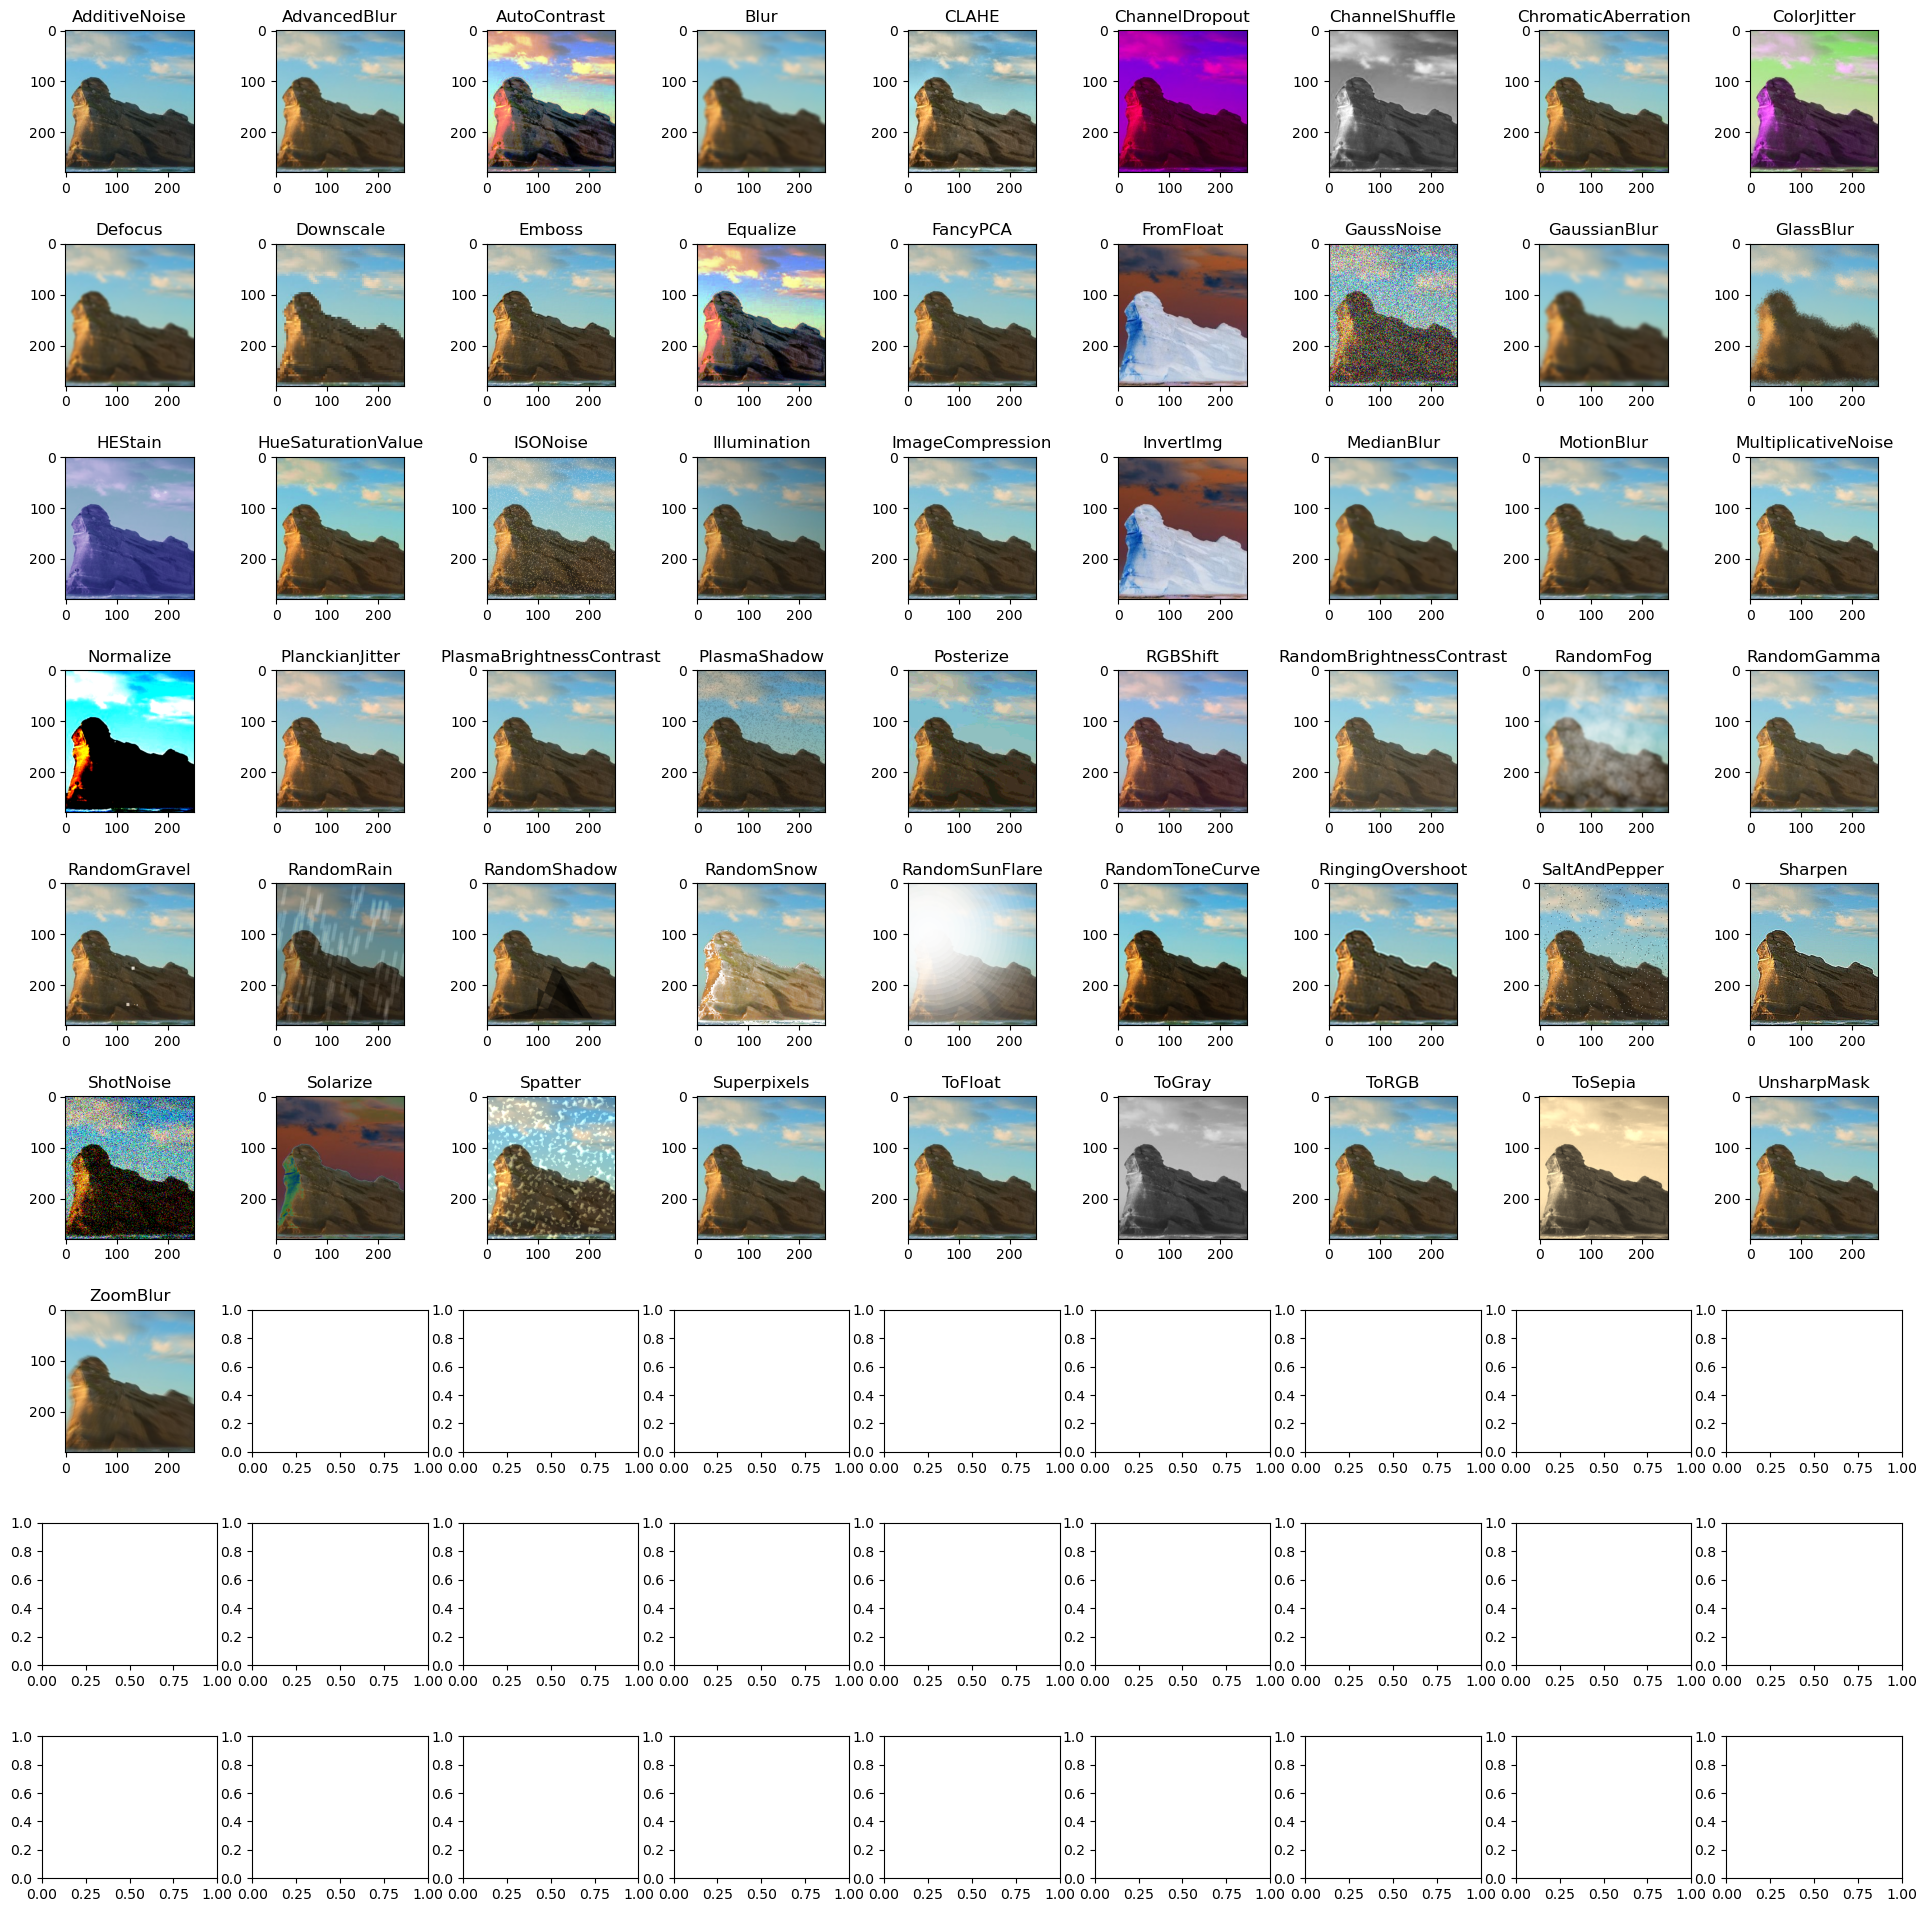

55


In [ ]:
import os
from matplotlib import pyplot as plt
import cv2
from importlib import import_module
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

# 读取 Lena 图片并转换为 RGB 格式
path_img = r"D:\ai\pytorch\l-PyTorch-Tutorial-2nd\data\imgs\lena.png"
image = cv2.imread(path_img)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 过滤出 albumentations 库中所有图像增强类
aug_list_cand = []
for attr_name in dir(A):
    # getattr(A, attr_name) 是 Python 的内置函数，它的主要作用是获取对象 A 的指定属性的值
    attr = getattr(A, attr_name)
    # isinstance() 是 Python 的内置函数，用于判断一个对象是否是某个类或类型的实例。
    # issubclass() 也是 Python 的内置函数，用于判断一个类是否是另一个类的子类
    if isinstance(attr, type) and issubclass(attr, ImageOnlyTransform):
        aug_list_cand.append(attr_name)

counter = 0
f, ax = plt.subplots(9, 9, figsize=(24, 24))
f.subplots_adjust(wspace=0.2, hspace=0.5)

for idx, aug_name in enumerate(aug_list_cand):
    try:
        # 创建数据增强对象
        data_transform = getattr(A, aug_name)(p=1)
        data_augmented = data_transform(image=image_rgb)
        image_aug = data_augmented['image']

        # 确保图像数组的数据类型为 uint8
        if image_aug.dtype not in [np.uint8, np.int16, np.float32, np.float64]:
            image_aug = image_aug.astype(np.uint8)

        counter += 1
        ax.ravel()[counter - 1].imshow(image_aug)
        ax.ravel()[counter - 1].set_title(aug_name)
    except Exception as e:
        print(f"Error applying {aug_name}: {e}")

plt.savefig("aug_demo-68.png")
plt.show()
print(counter)